In [3]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles

In [1]:
function time_moving_average(t::Vector{Float64},
                             x::Vector{Float64},
                             dt::Float64)
    n = length(t)
    x_10kyr = zeros(n)
    last_valid = NaN

    for i in 1:n
        t_start = t[i] - dt / 2
        t_end = t[i] + dt / 2

        # Find points in the time window
        idx = findall(tj -> t_start ≤ tj ≤ t_end, t)

        if !isempty(idx)
            x_10kyr[i] = mean(x[idx])
            last_valid = x_10kyr[i]
        else
            x_10kyr[i] = last_valid
        end
    end

    return x_10kyr
end


time_moving_average (generic function with 1 method)

In [4]:
myr = 1.0e6;
recurrence = 3030/myr;         # average recurrence time (Myr)
nevents = 40000;
tevent = rand(Exponential(recurrence),nevents);  # Poisson event times

# plot distribution of event times
println("mean recurrence time = ",mean(tevent)," Myr")
histogram(tevent,label="event times",xlabel="event time (Myr)",ylabel="Number")

Amax = 0.84
Amin = -0.45
amp_p = rand(Uniform(Amin,Amax),nevents)

# include random (white) noise
np = rand(Normal(),2*nevents); #called wi in paper
qp = 45;       #  gaussian noise variance

# set level of quenching
x0 = 5.0;
# allocate memory for solution
x = zeros(2*nevents);
t = zeros(2*nevents);


# decay rate for dipole (gamma = 1/tau)
gamma = 0.025 * 1000;    # convert to Myr

# initial condition
t[1] = 0.0;
x[1] = 5.0;
j = 2;

# integrate of number of events
for i = j : nevents
    
    # magnetic diffusion over half time step dt
    dt = tevent[i]/2.0;
    t[j] = t[j-1] + dt;
    gp = exp(-x[j-1]^2/1.8^2);  # x-dependence of gaussian noise
    x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;
    
    # magnetic diffusion over remaining time step
    j += 1;
    t[j] = t[j-1] + dt;
    x[j] = x[j-1] * exp(-gamma * dt)
    
    # evaluate quenching
    fp = 1.0/ (1.0 + (x[j]/x0)^2);
    gp = exp(-x[j]^2/1.8^2);
    
    # add event and random noise
    x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
    j+= 1;
    
end
t[end] = t[end-1]
x[end] = x[end-1]
println("mean x = ",mean(abs.(x))," std x = ",std(abs.(x)))

mean recurrence time = 0.003050684442521375 Myr
mean x = 5.903822360284315 std x = 2.7329132893221075


## Time moving average 

In [5]:
x_10kyr = time_moving_average(t,x, 0.01)

80000-element Vector{Float64}:
  4.122310558491237
  4.085600445606343
  3.996632051718577
  3.996632051718577
  3.9119433451404246
  3.799441630539594
  3.6793857935935526
  3.6793857935935526
  3.536046109068732
  3.2644497077615227
  3.155422239023511
  2.4580513059937927
  3.0318681505890566
  ⋮
 -5.9772030942958905
 -6.161246758183592
 -6.272392992719711
 -6.301056519991576
 -6.301056519991576
 -6.456628495913608
 -6.918256263620391
 -6.918256263620391
 -6.882014100488473
 -6.882014100488473
 -6.882014100488473
 -6.882014100488473

In [6]:
zero_crossings = sum(sign(x_10kyr[i]) != sign(x_10kyr[i+1]) for i in 1:length(x_10kyr)-1)

println("Zero crossings: ", zero_crossings)

Zero crossings: 143


In [7]:
x_30kyr = time_moving_average(t,x, 0.03)
zero_crossings = sum(sign(x_30kyr[i]) != sign(x_30kyr[i+1]) for i in 1:length(x_30kyr)-1)

println("Zero crossings: ", zero_crossings)

Zero crossings: 79


In [8]:
dts = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.15, 0.2, 0.3, 1]
reversals = zeros(length(dts))
i=1
for dt in dts
    x_30kyr = time_moving_average(t,x, dt)
    zero_crossings = sum(sign(x_30kyr[i]) != sign(x_30kyr[i+1]) for i in 1:length(x_30kyr)-1)
    
    println("Zero crossings: ", zero_crossings)
    reversals[i] = zero_crossings
    i+=1
    end

Zero crossings: 275
Zero crossings: 239
Zero crossings: 197
Zero crossings: 171
Zero crossings: 153
Zero crossings: 143
Zero crossings: 101
Zero crossings: 79
Zero crossings: 75
Zero crossings: 69
Zero crossings: 65
Zero crossings: 67
Zero crossings: 59
Zero crossings: 61
Zero crossings: 65
Zero crossings: 63
Zero crossings: 59
Zero crossings: 49
Zero crossings: 41
Zero crossings: 37


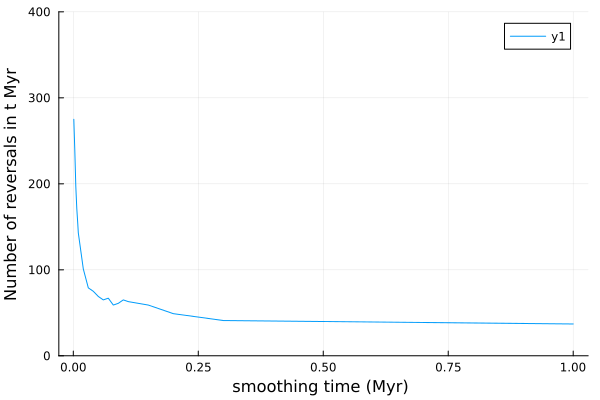

In [9]:
plot(dts, reversals,     
    ylim=(0,400),
    xlabel="smoothing time (Myr) ",
    ylabel="Number of reversals in t Myr"
)